## Setup and imports

In [2]:
# @title Install packages

# get the latest JAX and jaxlib
!pip install --upgrade -q jax jaxlib

# Colab runtime set to TPU accel
import requests
import os
if 'TPU_DRIVER_MODE' not in globals():
  url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
  resp = requests.post(url)
  TPU_DRIVER_MODE = 1

# TPU driver as backend for JAX
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
print(config.FLAGS.jax_backend_target)

# Install jetpack visualization library
!pip install git+https://github.com/nirum/jetpack/

# Install renn
!pip install renn

grpc://10.67.224.130:8470
  Cloning https://github.com/nirum/jetpack/ to /tmp/pip-req-build-get3mtn4
  Running command git clone -q https://github.com/nirum/jetpack/ /tmp/pip-req-build-get3mtn4
  Created wheel for jetpack: filename=jetpack-0.2.1-cp36-none-any.whl size=12585 sha256=c8d1d20099d87efc662c89ba928950bb65ff4836c4f8dddadbbe849b140e7322
  Stored in directory: /tmp/pip-ephem-wheel-cache-qq1336it/wheels/fd/56/f8/1f8ff4858f1596670024869c086ec5ed1adffbb9da0ff5e3b0
Successfully built jetpack


We use the [renn](https://reverse-engineering-neural-networks.readthedocs.io/en/latest/) package to build and analyze learned optimizers.

In [3]:
import jax
import jax.numpy as jnp
from jax.experimental import optimizers

import renn
from renn import metaopt

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
from sklearn.decomposition import PCA

from functools import partial
import toolz
import jetpack
import tqdm

from matplotlib import rcParams
rcParams['figure.dpi'] = 200

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2015232/45929032 bytes (4.4%)5242880/45929032 bytes (11.4%)8601600/45929032 bytes (18.7%)11730944/45929032 bytes (25.5%)14729216/45929032 bytes (32.1%)17866752/45929032 bytes (38.9%)21282816/45929032 bytes (46.3%)24625152/45929032 bytes (53.6%)27844608/45929032 bytes (60.6%)31154176/45929032 bytes (67.8%)34463744/45929032 bytes (75.0%)37675008/45929032 bytes (82.0%)

In [59]:
print(f'Using renn version {renn.__version__}')
print(f'Using jax version {jax.__version__}')

base_key = jax.random.PRNGKey(0)

Using renn version 0.0.3
Using jax version 0.2.9


## Build target optimization problem

In [60]:
# Builds a quadratic task distribution.
# - Individual optimization problems are sampled from this distribution.
# - Each sampled problem is a quadratic loss defined over n parameters.
# - The Hessian of each sampled problem has eigenvalues between 1e-3 and 1e0.
problem_fun = metaopt.tasks.quad(n=5, lambda_min=-3, lambda_max=0)

# Sample a single optimization problem from this task distribution.
base_key, key = jax.random.split(base_key)
x0, loss_fun = problem_fun(key)

print(loss_fun(x0, _))

28.982655


In [61]:
# Print the eigenvalues of the Hessian for this problem instance.
H = jax.hessian(loss_fun)(x0, _)
print(H.shape)

print(f'Eigenvalues are: {np.linalg.eigvalsh(H)}')

(5, 5)
Eigenvalues are: [0.00327664 0.00415914 0.01466051 0.32256594 0.7074792 ]


## Meta-learning a learning rate

In [62]:
num_iterations = 201

# Build a function that runs the "inner" optimization loop on our problem.
sgd_fun = metaopt.build_metaobj(problem_fun, optimizers.sgd, num_iterations)

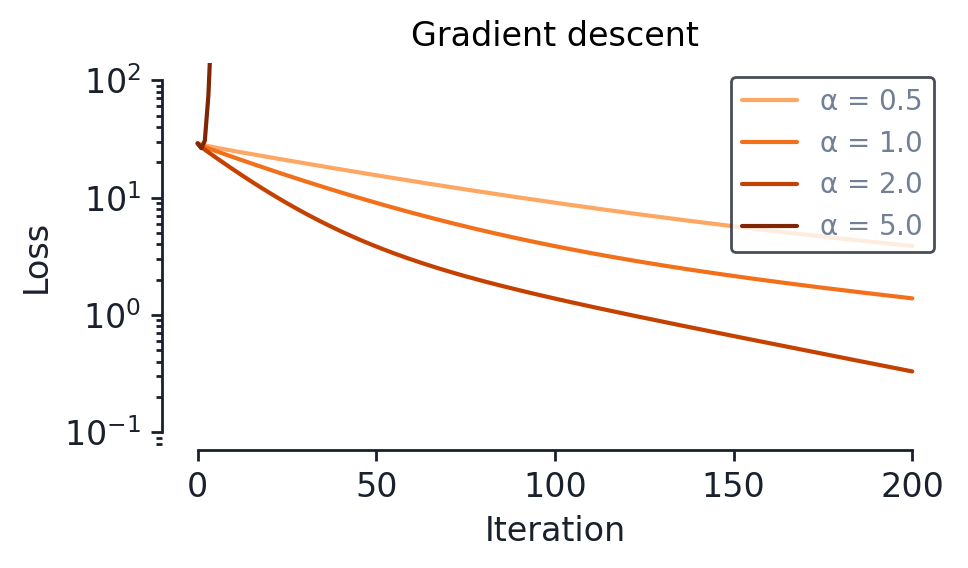

In [64]:
alphas = [0.5, 1.0, 2.0, 5.0]

colors = jetpack.colors.cmap_colors('Oranges', len(alphas), vmin=0.4)
for alpha, color in zip(alphas, colors):
  meta_objective, train_loss = sgd_fun(alpha, key)
  plt.semilogy(train_loss, label=r'$\alpha$ = ' + str(alpha), color=color)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Gradient descent', color='k')
plt.legend(loc=1, frameon=True)
plt.ylim(1e-1, 1e2)
jetpack.breathe()

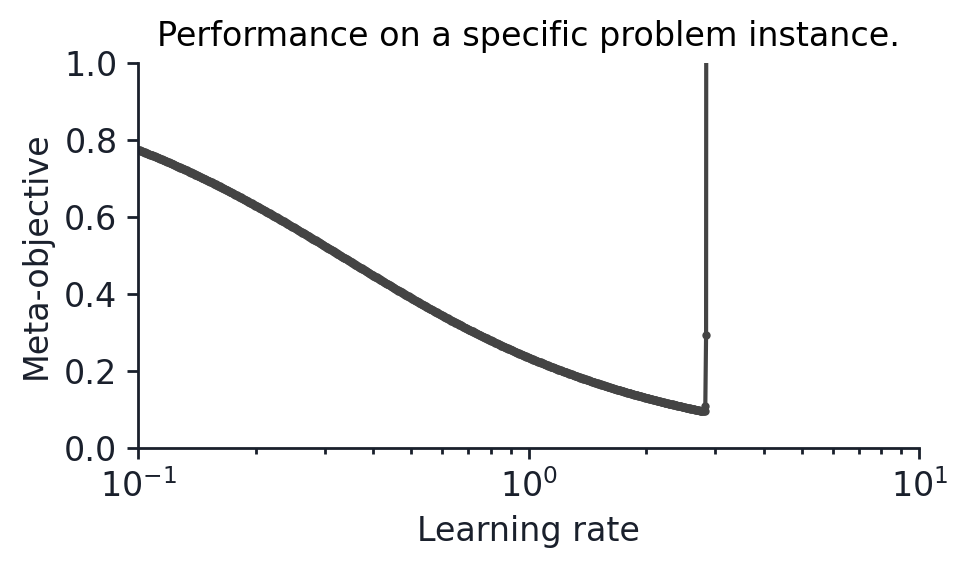

In [65]:
# Use jax.vmap to run the meta-objective on an array of learning rates.
mobj = jax.vmap(toolz.compose(lambda x: x[0], sgd_fun), in_axes=(0, None))

# Learning rates to test.
alphas = np.logspace(-1, 1, 1001)

# Test these on a particular problem instance.
scores = mobj(alphas, key)

plt.semilogx(alphas, scores, '.-', color='#444444')
plt.ylim(0, 1)
plt.xlim(1e-1, 1e1)
plt.ylabel('Meta-objective')
plt.xlabel('Learning rate')
plt.title('Performance on a specific problem instance.', color='k')
jetpack.nospines()

  x = asanyarray(arr - arrmean)

  x = um.multiply(x, x, out=x)




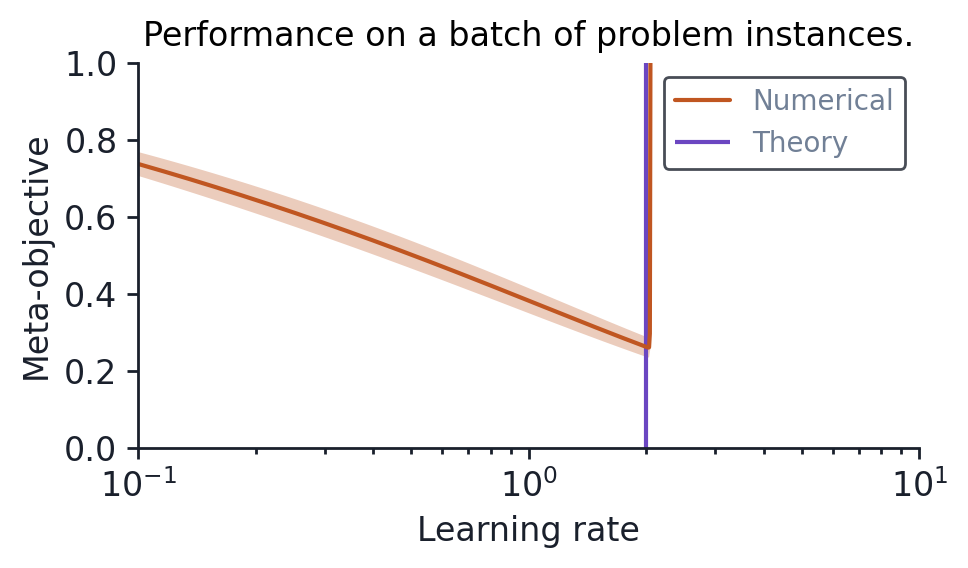

In [67]:
batch_mobj = jax.vmap(mobj, in_axes=(None, 0))

test_keys = jax.random.split(key, 64)
scores = np.array(batch_mobj(alphas, test_keys))

fig, ax = plt.subplots()
jetpack.errorplot(alphas, np.nanmean(scores, axis=0), sem(scores, axis=0), ax=ax, color=jetpack.colors.orange.v7)
ax.set_xscale('log')
ax.set_ylim(0, 1)
ax.set_xlim(1e-1, 1e1)

plt.ylabel('Meta-objective')
plt.xlabel('Learning rate')
plt.title('Performance on a batch of problem instances.', color='k')

alpha_star = 2 / (1e-3 + 1e0)     # optimal learning rate: 2 / (lambda_min + lambda_max)
ax.vlines(alpha_star, 0, 1, colors=jetpack.colors.purple.v7, label='Theory')
plt.legend(('Numerical', '_nolegend_', 'Theory'), frameon=True)

jetpack.nospines()

## Building learned optimizers

### Learned optimizer architecture

In [68]:
base_key, model_key, train_key = jax.random.split(base_key, 3)

# Parameterize the optimizer using an RNN with 64 units.
cell = renn.GRU(64)

# Build RNN Optimizer.
# - optimizer_fun returns a jax.experimental.optimizers.Optimizer object
# - theta_init is a pytree of the meta-parameters of the optimizer (here, the RNN weights)
theta_init, optimizer_fun = metaopt.models.cwrnn(key, cell, output_scale=1.0)

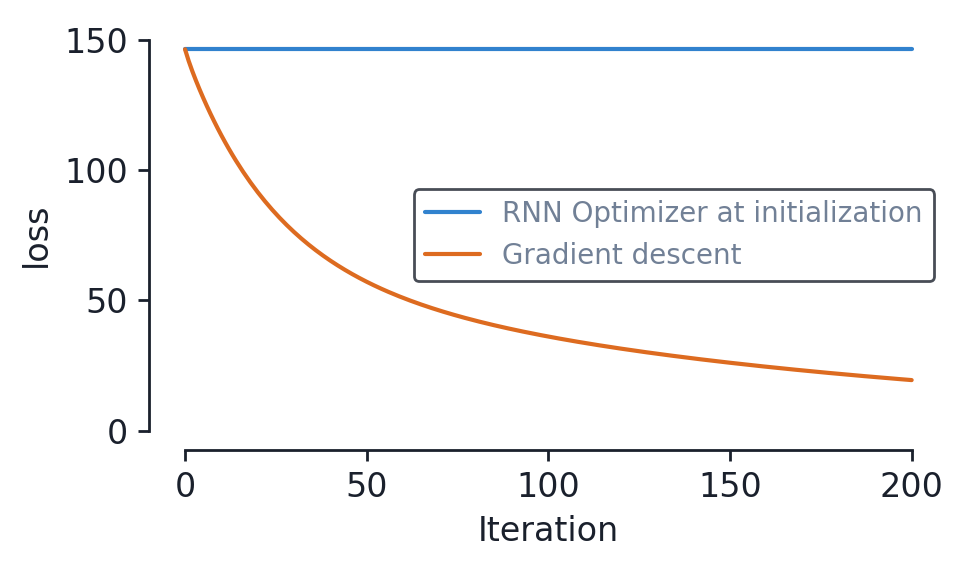

In [69]:
# Apply the RNN Optimizer on our target problem.
rnn_fun = metaopt.build_metaobj(problem_fun, optimizer_fun, num_iterations, l2_penalty=1e-4)
_, fs = rnn_fun(theta_init, train_key)

plt.plot(fs, label='RNN Optimizer at initialization', color=jetpack.colors.blue.v6)
plt.plot(sgd_fun(alpha_star, train_key)[1], label='Gradient descent', color=jetpack.colors.orange.v6)
plt.legend(frameon=True)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.ylim(0, 150)
jetpack.breathe()

### Meta-train the learned optimizer

In [72]:
# Meta-optimization hyperparameters
batch_size = 64
lr = optimizers.exponential_decay(8e-3, 1000, 0.5)
init_opt, update_opt, get_params = optimizers.adam(step_size=lr, b1=0.9, b2=0.999, eps=0.1)
opt_state = init_opt(theta_init)

# Define the meta-loss and meta-gradient over a batch of unrolled optimization runs.
batch_mobj = renn.batch_mean(toolz.compose(renn.fst, rnn_fun), (None, 0))
meta_val_and_grad = jax.value_and_grad(batch_mobj)

# Used for clipping the meta-gradient
clip_fun = partial(metaopt.clip, value=5.0)

@jax.jit
def outer_step(step, state):

  # Random seeds for this batch of problems.
  prng_key = jax.random.fold_in(train_key, step)
  keys = jax.random.split(prng_key, batch_size)

  # Get meta-parameters.
  meta_params = get_params(state)

  # Evaluate meta-objective and gradient on this batch of problems.
  mobj, mgrad = meta_val_and_grad(meta_params, keys)
  clipped_mgrad = jax.tree_map(clip_fun, mgrad)

  # Update meta-parameters.
  state = update_opt(step, clipped_mgrad, state)

  return mobj, state

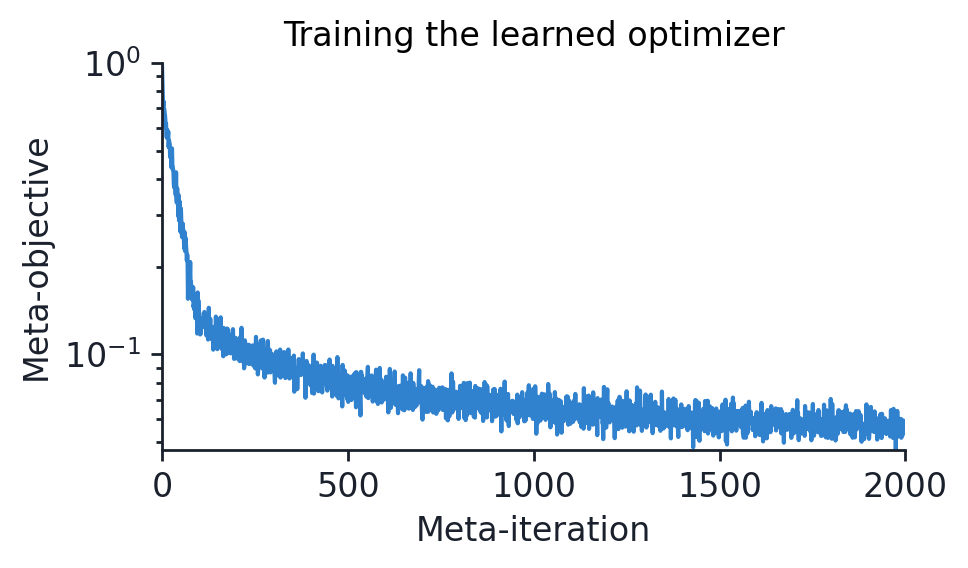

In [73]:
# Run meta-training loop!
save_every = 500
thetas = [theta_init,]

fs = []
for step in tqdm.notebook.tqdm(range(2001)):

  # Take a meta-optimization (outer) step, store the meta-objective.
  f, opt_state = outer_step(step, opt_state)
  fs.append(f)

  # Store meta-parameters?
  if step % save_every == 0:
    thetas.append(get_params(opt_state))

fs = np.array(fs)

plt.semilogy(fs)
plt.xlabel('Meta-iteration')
plt.ylabel('Meta-objective')
plt.title('Training the learned optimizer', color='k')
jetpack.nospines()

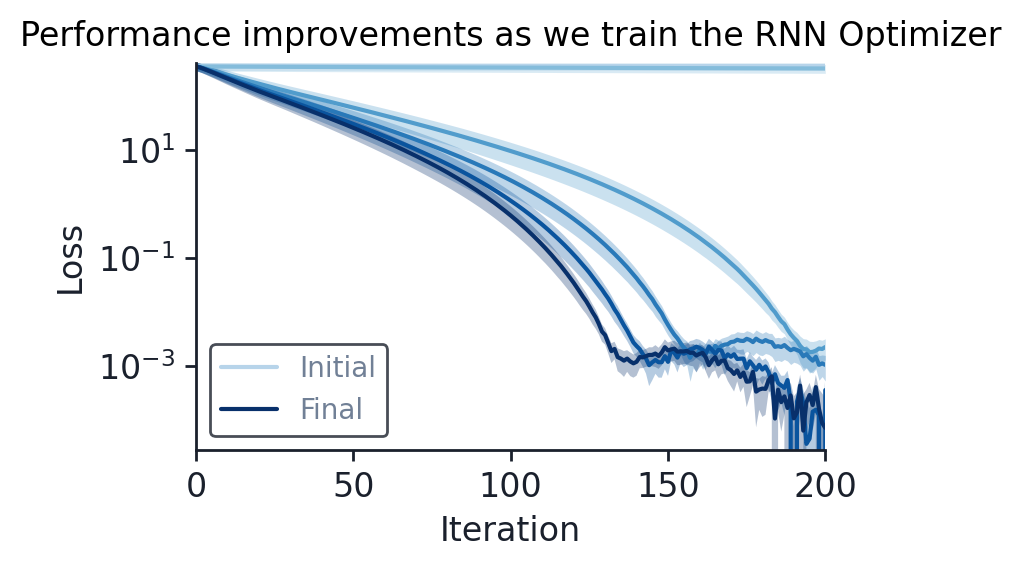

In [74]:
test_rnn_fun = jax.jit(jax.vmap(toolz.compose(renn.snd, rnn_fun), in_axes=(None, 0)))

fig, ax = plt.subplots()

colors = jetpack.colors.cmap_colors('Blues', len(thetas), vmin=0.3)
for theta, color in zip(thetas, colors):
  losses =  test_rnn_fun(theta, test_keys)
  jetpack.errorplot(np.arange(num_iterations), np.mean(losses, axis=0), sem(losses, axis=0), color=color, ax=ax)

ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Performance improvements as we train the RNN Optimizer', color='k')

labels = ['_no_legend_' for _ in range(len(thetas))]
labels[0] = 'Initial'
labels[-1] = 'Final'
ax.legend(labels, frameon=True, loc=3)
jetpack.nospines(ax=ax)

### Performance comparison

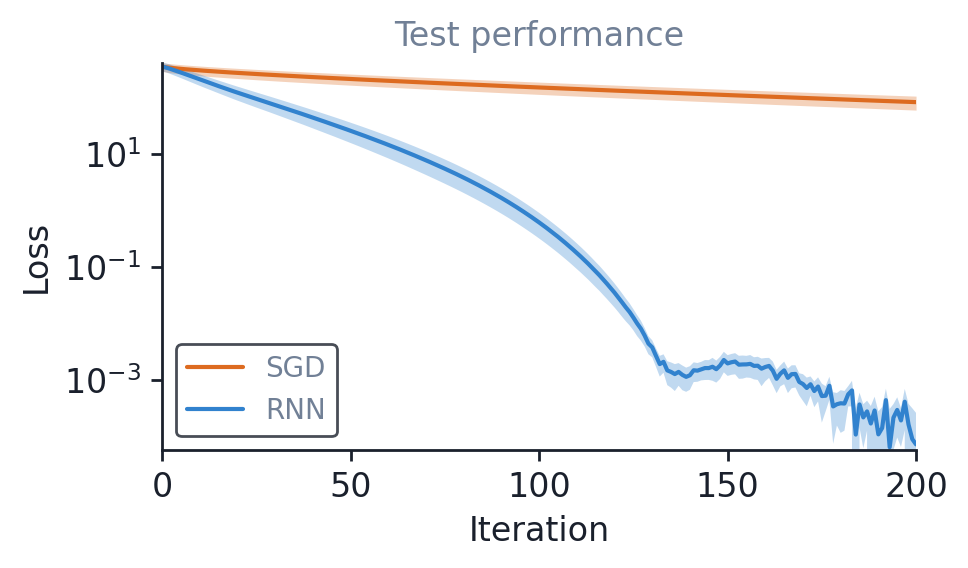

In [75]:
# Test RNN Optimizer.
rnn_losses = test_rnn_fun(thetas[-1], test_keys)

# Test gradient descent.
test_sgd_fun = jax.jit(jax.vmap(toolz.compose(renn.snd, sgd_fun), in_axes=(None, 0)))
sgd_losses = test_sgd_fun(alpha_star, test_keys)

fig, ax = plt.subplots()
jetpack.errorplot(np.arange(num_iterations), np.mean(sgd_losses, axis=0), sem(sgd_losses, axis=0), color=jetpack.colors.orange.v6, ax=ax)
jetpack.errorplot(np.arange(num_iterations), np.mean(rnn_losses, axis=0), sem(rnn_losses, axis=0), color=jetpack.colors.blue.v6, ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Test performance')
ax.legend(['SGD', 'RNN'], frameon=True, loc=0)
jetpack.nospines(ax=ax)

## Analyzing the optimizer

In [76]:
# Destructure optimizer parameters
theta_final = get_params(opt_state)
cell_params, readout_params = theta_final

In [79]:
# Run the optimizer on a test problem, store additional data for analysis
store = metaopt.unroll_for(*problem_fun(key), optimizer_fun(theta_final), renn.snd, tqdm.trange(101))

100%|██████████| 101/101 [00:11<00:00,  9.15it/s]


In [80]:
# Store contains the loss, parameters, optimizer state, and gradients from each iteration
# while the optimizer was running on a given problem.
print(store.keys())

dict_keys(['loss', 'params', 'state', 'gradient'])


### State space visualization

In [81]:
# Collect the set of optimizer (RNN) states that were visited when solving this problem.
hs = np.stack(list(map(np.vstack, store['state'])))
print(f'(Num iterations, problem dimension, # of RNN units)')
print(hs.shape)

(Num iterations, problem dimension, # of RNN units)
(101, 5, 64)


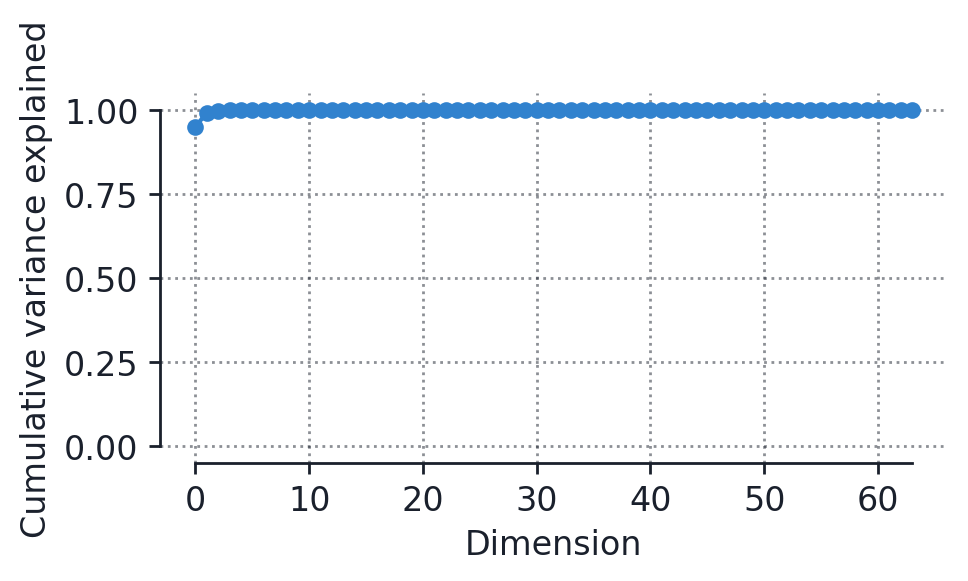

In [82]:
pca = PCA().fit(np.vstack(hs))

plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.ylim(0, 1)
plt.grid()
plt.xlabel('Dimension')
plt.ylabel('Cumulative variance explained')
jetpack.breathe()

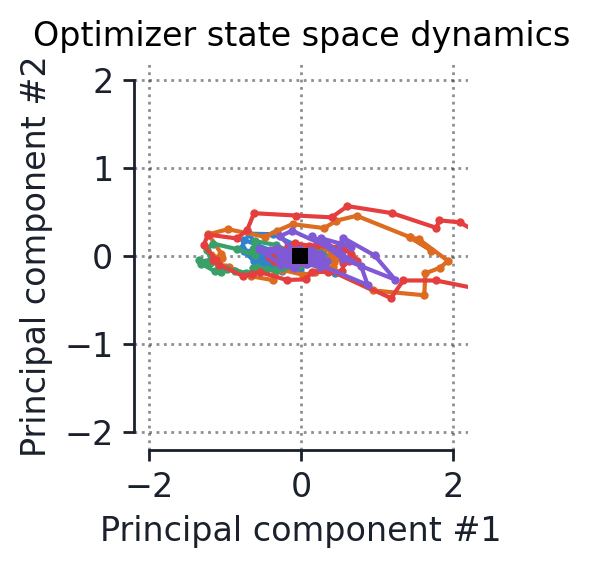

In [86]:
fig = plt.figure(figsize=(3, 3))

for k in range(5):
  hx, hy = pca.transform(hs[:, k]).T[:2]
  plt.plot(hx, hy, '.-')

plt.plot(hx[0], hy[0], 'ks')

plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel('Principal component #1')
plt.ylabel('Principal component #2')
plt.title('Optimizer state space dynamics', color='k')
plt.grid()
jetpack.breathe()

### Update functions

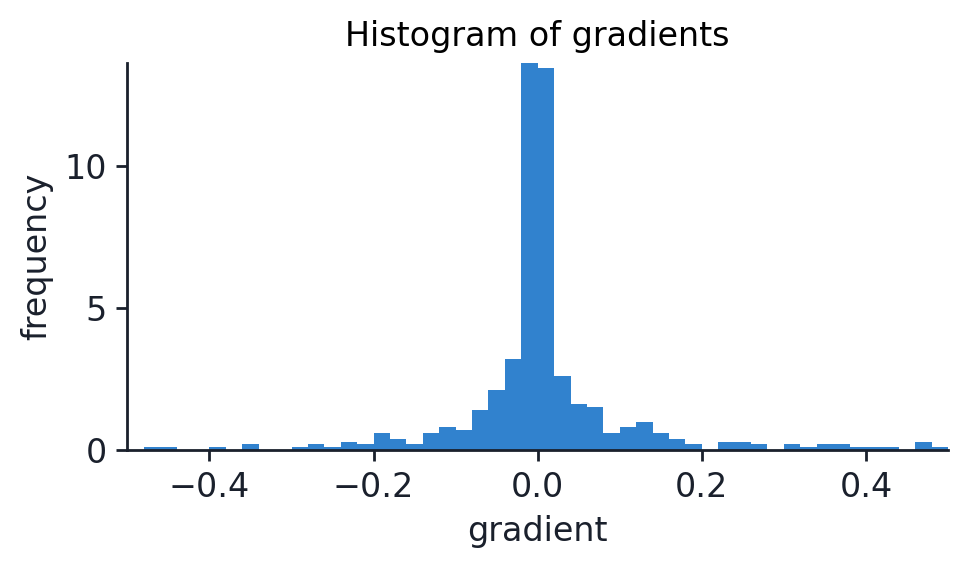

In [87]:
bins = np.linspace(-0.5, 0.5, 51)
plt.hist(np.stack(store['gradient']).ravel(), bins, density=True);
plt.ylabel('frequency')
plt.xlabel('gradient')
plt.title('Histogram of gradients', color='k')
jetpack.nospines()

In [88]:
gradients = np.linspace(-0.5, 0.5, 1001)
readout_apply = jax.experimental.stax.Dense(1)[1]

@jax.jit
def update_function(h):
  states = jnp.reshape(h, (1, -1)) * jnp.ones((gradients.size, 1))
  h_next = cell.batch_apply(cell_params, jnp.reshape(gradients, (-1, 1)), states)
  return jnp.squeeze(readout_apply(readout_params, h_next))

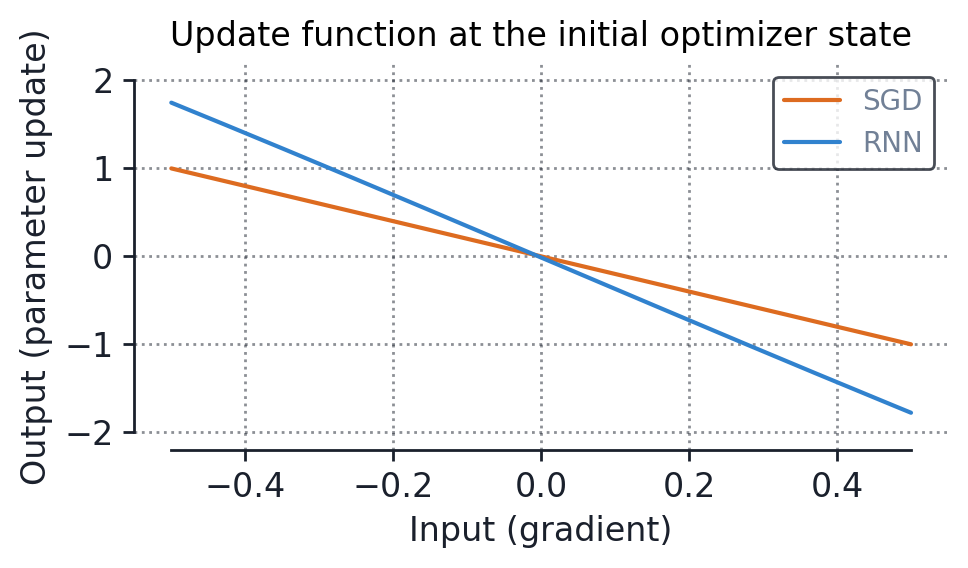

In [89]:
h0 = cell.get_initial_state(cell_params)

plt.title('Update function at the initial optimizer state', color='k')
plt.plot(gradients, -alpha_star * gradients, color=jetpack.colors.orange.v6, label='SGD')
plt.plot(gradients, np.array(update_function(h0)), color=jetpack.colors.blue.v6, label='RNN')
plt.xlabel('Input (gradient)')
plt.ylabel('Output (parameter update)')
plt.grid()
plt.ylim(-2, 2)
jetpack.breathe()
plt.legend(frameon=True)

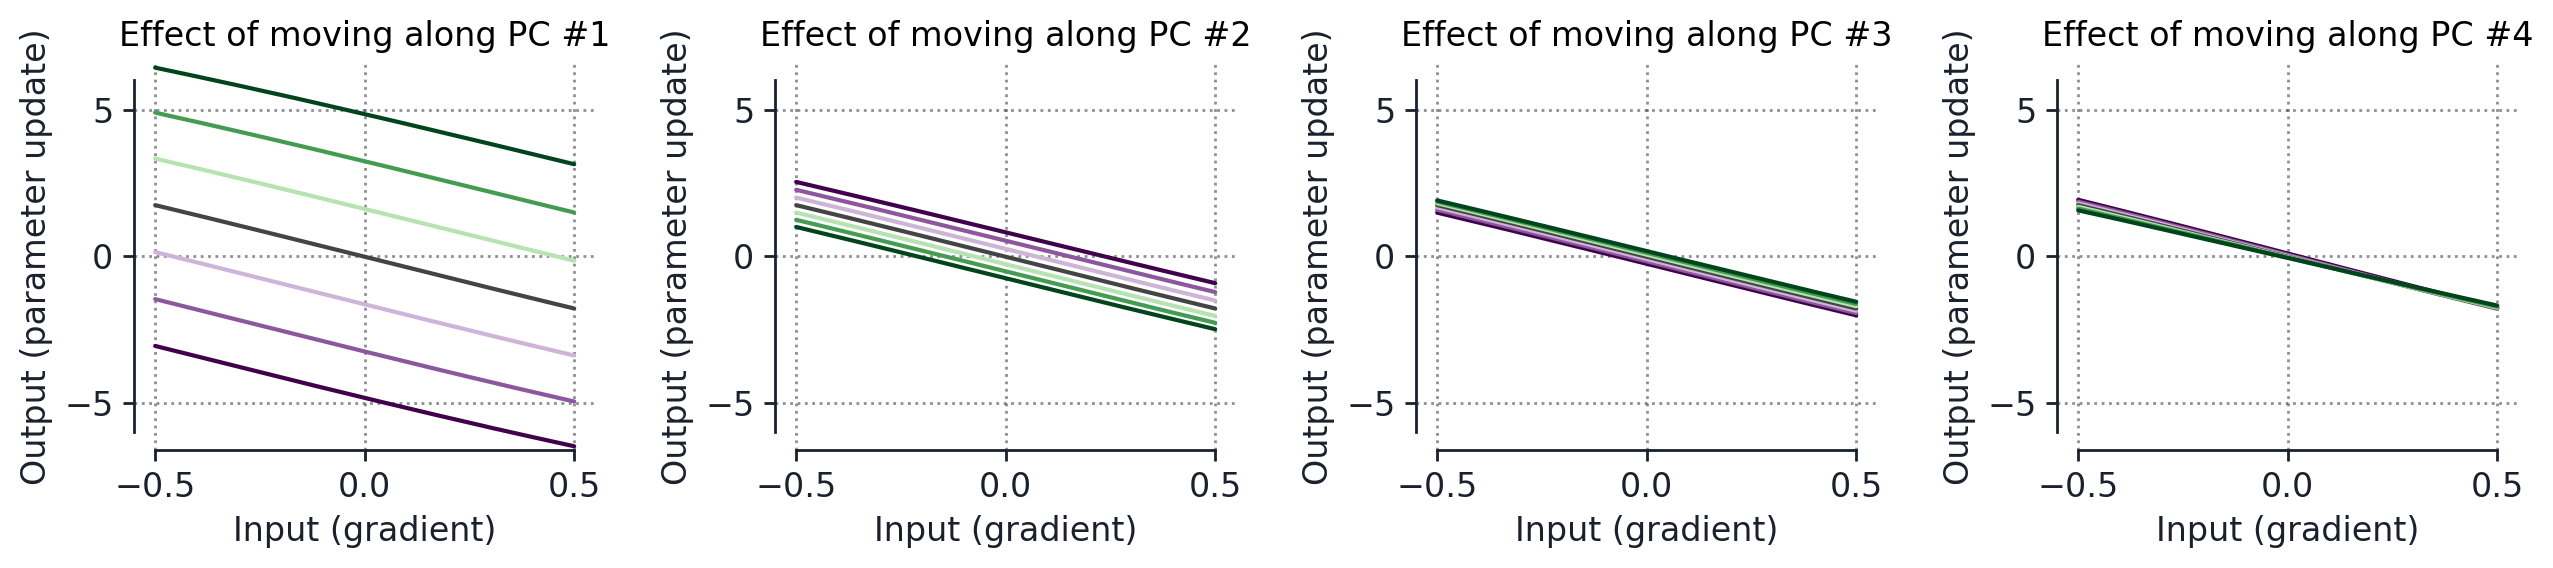

In [103]:
N = 4
fig, axs = plt.subplots(1, N, figsize=(3.25 * N, 3))

deltas = np.linspace(-2, 2, 7)
colors = list(jetpack.colors.cmap_colors('PRGn', len(deltas)))
colors[len(colors) // 2] = '#444444'

for idx, ax in enumerate(axs):
  eigenvector = pca.components_[idx]
  
  for delta, color in zip(deltas, colors):
    h = h0 + delta * eigenvector
    ax.plot(gradients, update_function(h), '-', color=color)
  
  ax.set_xlabel('Input (gradient)')
  ax.set_ylabel('Output (parameter update)')
  ax.set_title(f'Effect of moving along PC #{idx+1}', color='k')
  ax.grid()
  ax.set_ylim(-6, 6)
  jetpack.breathe(ax=ax)

### Dynamical systems analyses

In [92]:
# Find numerical fixed points of the optimizer dynamics.
opt = optimizers.adam(0.01)
fp_loss_fun = renn.build_fixed_point_loss(cell, cell_params)
fps, loss_hist, fp_losses = renn.find_fixed_points(
    fp_loss_fun,
    np.vstack(hs),
    jnp.zeros((505, 1)),
    opt,
    tolerance=1e-8,
    num_steps=1000)

100%|██████████| 1000/1000 [00:07<00:00, 129.83it/s]


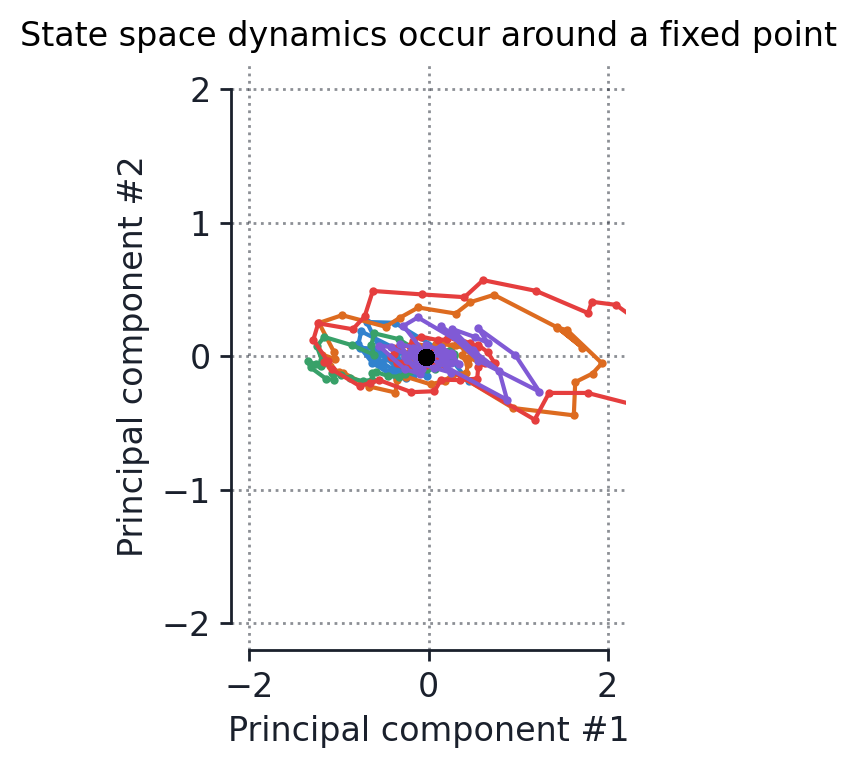

In [93]:
fig = plt.figure(figsize=(4, 4))

for k in range(5):
  hx, hy = pca.transform(hs[:, k]).T[:2]
  plt.plot(hx, hy, '.-')

fx, fy = pca.transform(fps).T[:2]
plt.plot(fx, fy, 'ko')

plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel('Principal component #1')
plt.ylabel('Principal component #2')
plt.title('State space dynamics occur around a fixed point', color='k')
plt.grid()
jetpack.breathe()

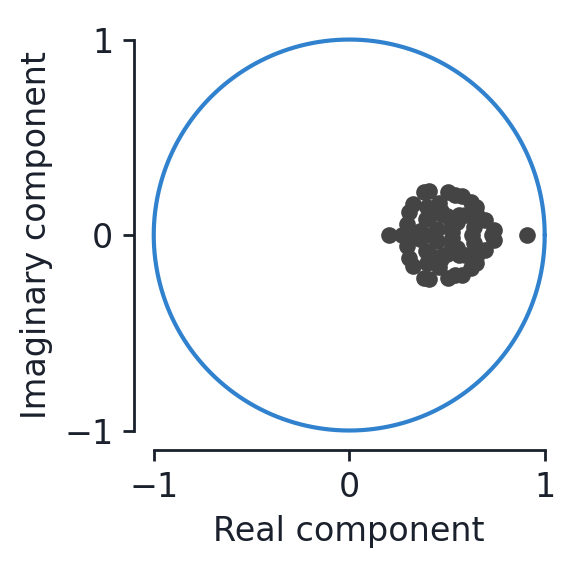

In [94]:
# Analyze the Jacobian of the nonlinear dynamical system at the fixed point.
fp_star = fps[np.argmin(fp_losses)]
Jrec = cell.rec_jac(cell_params, jnp.zeros(1), fp_star)
Jinp = cell.inp_jac(cell_params, jnp.zeros(1), fp_star)
R, E, L = renn.eigsorted(Jrec)

fig, ax = plt.subplots(figsize=(3.25, 3))
ax.plot(np.real(E), np.imag(E), 'o', color='#444444')
ax.set_aspect('equal')
ax.set_xticks([-1, 0, 1])
ax.set_xlabel('Real component')
ax.set_ylabel('Imaginary component')
ax.set_yticks([-1, 0, 1])
jetpack.circle(ax=ax)
jetpack.breathe(ax=ax)

In [101]:
def optimal_params(lambda_min, lambda_max):
  """Returns optimal momentum hyperparameters.

  See also:
  - http://pages.cs.wisc.edu/~brecht/cs726docs/HeavyBallLinear.pdf
  - https://distill.pub/2017/momentum/
  """
  alpha_star = 4. / (np.sqrt(lambda_min) + np.sqrt(lambda_max)) ** 2
  beta_star = ((np.sqrt(lambda_max) - np.sqrt(lambda_min)) / 
               (np.sqrt(lambda_max) + np.sqrt(lambda_min))) ** 2
  return (alpha_star, beta_star)

  return array(a, dtype, copy=False, order=order)



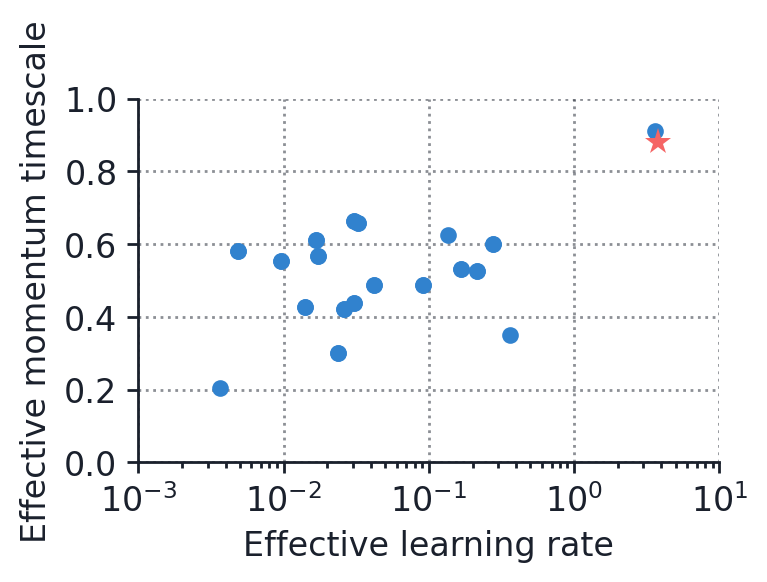

In [102]:
plt.figure(figsize=(4, 3))

w, b = readout_params
coeffs = jnp.squeeze(w.T.dot(R))
alphas = -coeffs * jnp.squeeze(L.T.dot(Jinp))
betas = jnp.array(E.copy())

plt.semilogx(alphas, np.abs(betas), 'o', color=jetpack.colors.blue.v6)
plt.xlim(1e-3, 1e1)
plt.ylim(0.0, 1.0)
plt.xlabel('Effective learning rate')
plt.ylabel('Effective momentum timescale')
plt.grid()
jetpack.nospines()

plt.plot(*optimal_params(1e-3, 1e0), '*', ms=10, color=jetpack.colors.red.v5)

## Final evaluation

In [98]:
key, eval_key = jax.random.split(key)
NUM_INNER = 201

def eval_optimizer(opt, num_repeats=64, num_steps=NUM_INNER, eval_key=eval_key):

  @jax.jit
  def meta_objective(problem_key):
    problem = problem_fun(problem_key)
    _, losses = metaopt.unroll_scan(*problem, opt, num_steps, renn.identity)
    return losses
  
  batch_mobj = jax.soft_pmap(meta_objective)
  keys = jax.random.split(eval_key, num=num_repeats)
  return batch_mobj(keys)

In [99]:
%%time

# Test RNN
rnn_fs = eval_optimizer(optimizer_fun(theta))

# Test Momentum
_, mom_fun = metaopt.models.momentum(key)
mom_fs = eval_optimizer(mom_fun(optimal_params(1e-3, 1e0)))

# Test SGD
sgd_fs = eval_optimizer(optimizers.sgd(alpha_star))

  warn("soft_pmap is an experimental feature and probably has bugs!")



CPU times: user 3.35 s, sys: 990 ms, total: 4.34 s
Wall time: 4.76 s


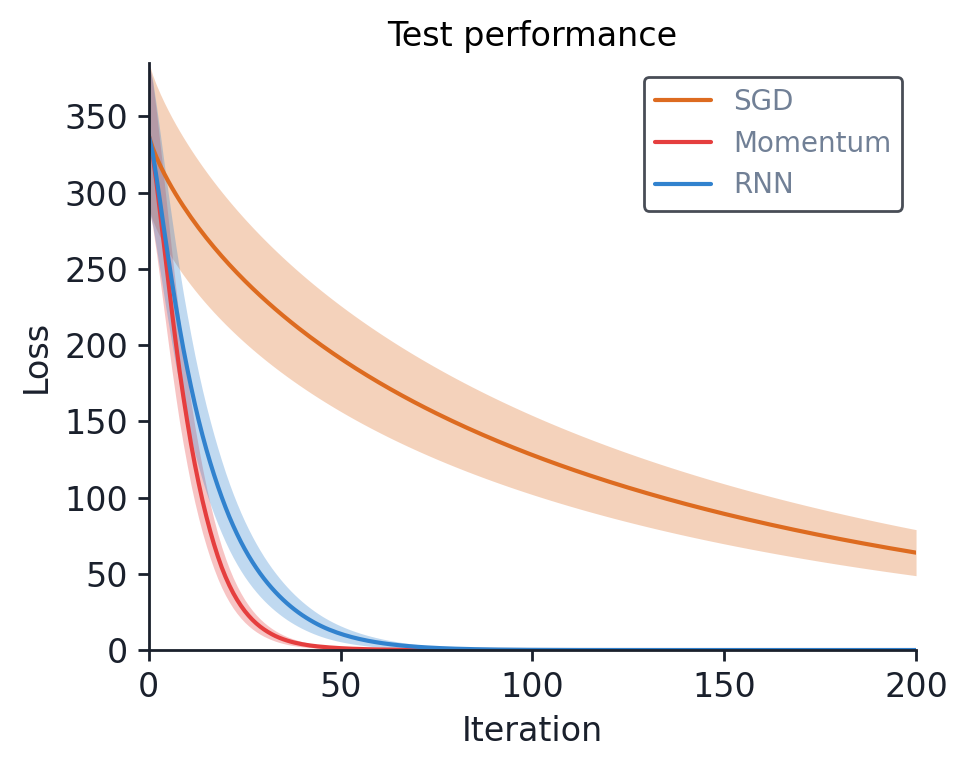

In [100]:
fig, ax = plt.subplots(figsize=(5, 4))
jetpack.errorplot(np.arange(201), sgd_fs.mean(axis=0), sem(sgd_fs, axis=0), ax=ax, color=jetpack.colors.orange.v6)
jetpack.errorplot(np.arange(201), mom_fs.mean(axis=0), sem(mom_fs, axis=0), ax=ax, color=jetpack.colors.red.v6)
jetpack.errorplot(np.arange(201), rnn_fs.mean(axis=0), sem(rnn_fs, axis=0), ax=ax, color=jetpack.colors.blue.v6)

ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Test performance', color='k')
ax.legend(('SGD', 'Momentum', 'RNN'), frameon=True)
jetpack.nospines()